# Noise Simulation Demo

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import qsttoolkit as qst

## Noise Sources

Quantum state noise is described as *state preparation and measurement* (SPAM) noise. Noise sources for optical quantum states simulated by QSTToolkit divide this definition into two categories:
- State preparation noise, arising from imperfect preparation and preservation of the state.
- Measurement and data noise, emerging from the measurement of the state and data collection.

Note that the levels of noise sources applied in this notebook are exaggerated to demonstrate their effect on measurement data.

First, we prepare a test coherent state:

In [2]:
dim = 32
data_dim = 32                 # Dimensions of the phase space grid that will serve as the image size for our data
xgrid = np.linspace(-5, 5, data_dim)
pgrid = np.linspace(-5, 5, data_dim)

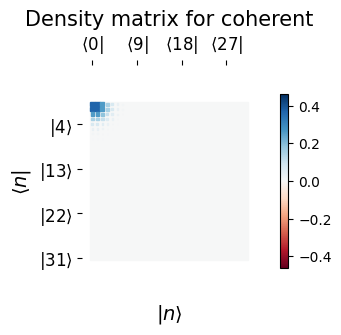

In [3]:
test_state = qt.coherent_dm(dim, 1.0)

qst.plot_Hinton(test_state, label='coherent')
plt.show()

### State preparation noise

Thermal mixing of the state with its environment is simulated by a weighted mixing of the pure state with a random mixed state:

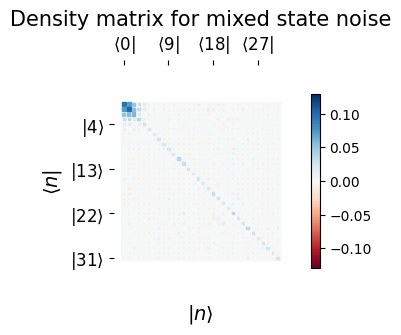

In [4]:
ms_noise = qst.mixed_state_noise(test_state, noise_level=0.8)

qst.plot_Hinton(ms_noise, label='mixed state noise')
plt.show()

### Measurement and data noise

We first create displace-and-measure phase space Husimi Q measurement data from the clean state:

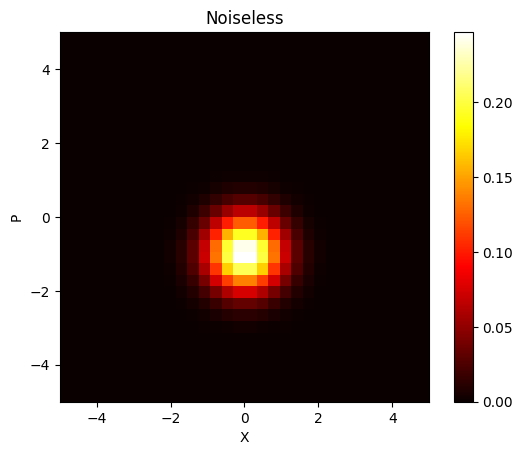

In [5]:
measurement_operators = qst.tomography.measurement_operators(dim, 'Husimi_Q', xgrid=xgrid, pgrid=pgrid)
expectation_values = qst.expectation(test_state, measurement_operators)
measurement_data = expectation_values.numpy().reshape(data_dim, data_dim)

plt.imshow(measurement_data, cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Noiseless')
plt.show()

Additional bosonic modes may arise from the amplification regime used for the optical states, modeled using a Gaussian convolution:

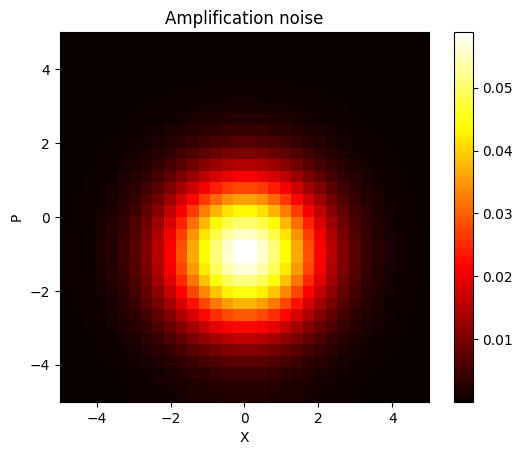

In [6]:
amp_noise = qst.gaussian_convolution(measurement_data, variance=4)

plt.imshow(amp_noise, cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Amplification noise')
plt.show()

Affine transformations may occur in the measured image due to inaccurate displacements or calibration of photon detectors:

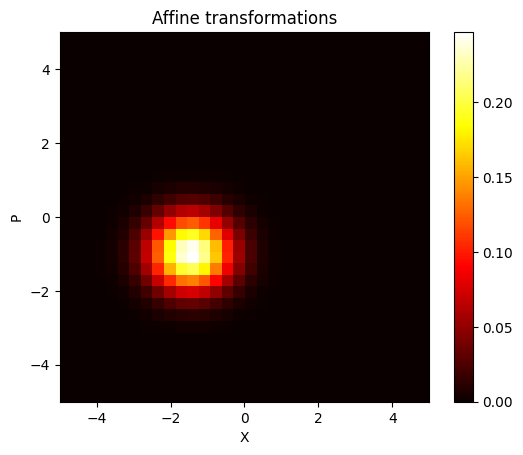

In [19]:
affine_noise = qst.affine_transformation(measurement_data, theta=30, x=0.4, y=0.4)

plt.imshow(affine_noise, cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Affine transformations')
plt.show()

Additive Gaussian noise is used to simulate the discretisation of a continuous phase space, as well as the finite measurement data limit:

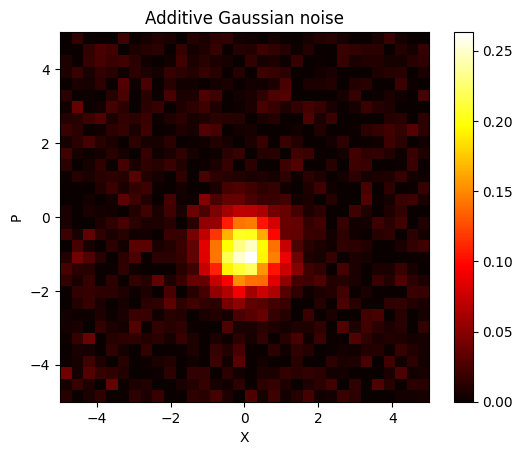

In [8]:
additive_noise = qst.additive_gaussian_noise(measurement_data, np.mean(measurement_data), 0.01)

plt.imshow(additive_noise, cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Additive Gaussian noise')
plt.show()

Pixel over-saturation and non-operation are simulated using 'salt-and-pepper noise', where a proportion of pixel probabilities ar fixed to 1 and 0:

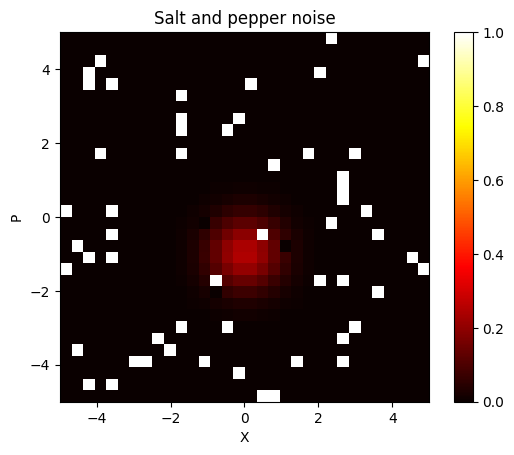

In [9]:
sp_noise = qst.salt_and_pepper_noise(measurement_data, pepper_p=0.05, salt_p=0.05)

plt.imshow(sp_noise, cmap='hot', extent=[-5, 5, -5, 5])
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.title('Salt and pepper noise')
plt.show()

### Combined noise

QSTToolkit provides `apply_measurement_noise()` which applies all measurement noise sources at once. All the above noise sources combined:

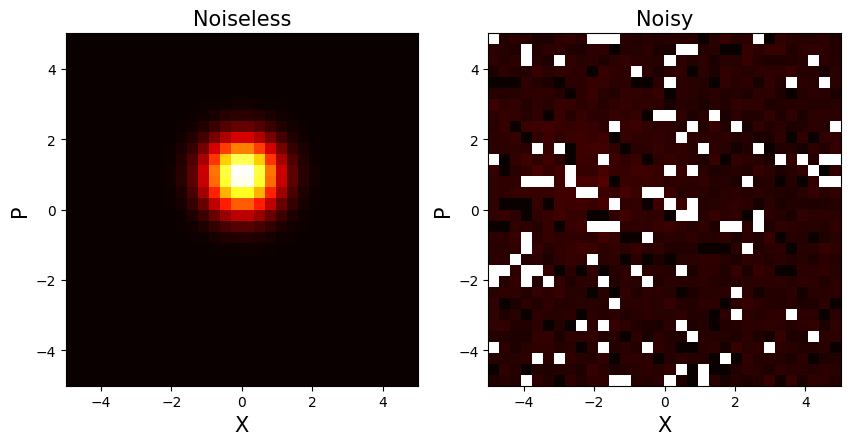

In [10]:
measurement_data = expectation_values.numpy().reshape(data_dim, data_dim)
ms_expectation_values = qst.expectation(ms_noise, measurement_operators)
ms_data = ms_expectation_values.numpy().reshape(data_dim, data_dim)
noisy_data = qst.apply_measurement_noise(qst.gaussian_convolution(ms_data, variance=4),
                                         affine_theta=30,
                                         affine_x=0.4,
                                         affine_y=0.4,
                                         additive_Gaussian_stddev=0.01,
                                         pepper_p=0.1,
                                         salt_p=0.1)

_, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(measurement_data, extent=[-5, 5, -5, 5], origin='lower', cmap='hot')
axs[0].set_title('Noiseless', fontsize=15)
axs[0].set_xlabel('X', fontsize=15)
axs[0].set_ylabel('P', fontsize=15)

axs[1].imshow(noisy_data, extent=[-5, 5, -5, 5], origin='lower', cmap='hot')
axs[1].set_title('Noisy', fontsize=15)
axs[1].set_xlabel('X', fontsize=15)
axs[1].set_ylabel('P', fontsize=15)

plt.show()

QSTToolkit provides `optical_state_dataset()` which produces the above dataset in one function, intended to be used as a standardised dataset for training models. All the implemented noise sources are applied to the generated data, with levels that can be adjusted in the arguments:

In [11]:
data = qst.data.optical_state_dataset(dim=32,
                                      data_dim=32,
                                      state_numbers=[1000, 1000, 1000, 1000, 1000, 1000, 0, 1000],       # Large numbers of GKP states take an intractable amount of time to produce, and are difficult to produce practically
                                      mixed_state_noise_level = 0.2,
                                      Gaussian_conv_ntherm = 2.0,
                                      affine_theta = 20.0,
                                      affine_x = 0.1,
                                      affine_y = 0.1,
                                      additive_Gaussian_stddev = 0.001,
                                      pepper_p = 0.01,
                                      salt_p = 0.0)

c:\Users\gwfit\OneDrive\Documents\Durham University Physics\Level 4\MPhys Project - Deep Learning Quantum Tomography\Code\qsttoolkit-private\qsttoolkit\data\state_batches.py:170: UserWarning: thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")
c:\Users\gwfit\OneDrive\Documents\Durham University Physics\Level 4\MPhys Project - Deep Learning Quantum Tomography\Code\qsttoolkit-private\qsttoolkit\data\state_batches.py:365: UserWarning: Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future

States generated
DataFrames initialized
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
GKP data generated
Random data generated
Dataset generated


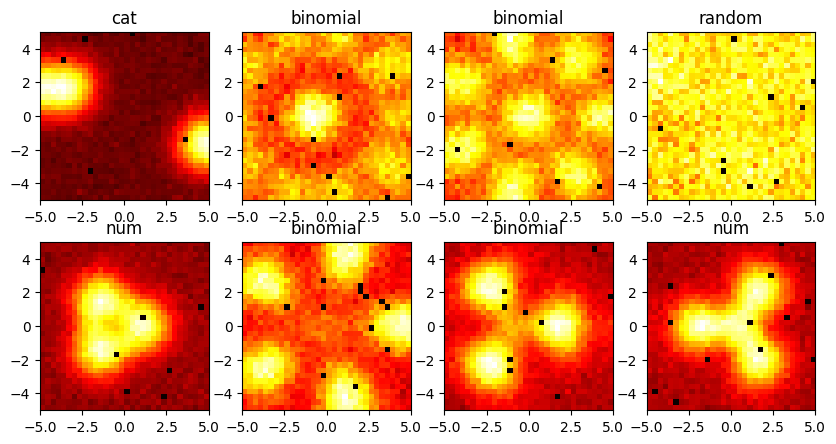

In [12]:
_, axs = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(data['Husimi-Q_function'][i], extent=[-5, 5, -5, 5], cmap='hot')
    ax.set_title(data['label'][i])